# Image Recognition with Transfer Learning (CIFAR-10 Dataset)

## Practical Test: Neural Networks & Deep Learning

This notebook implements transfer learning for image classification on the CIFAR-10 dataset using pre-trained model (MobileNetV2) and compares performance with a custom CNN.

### Dataset
- **CIFAR-10**: 60,000 32x32 color images in 10 classes
- Source: https://www.cs.toronto.edu/~kriz/cifar.html


In [3]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import time

print("TensorFlow version:", tf.__version__)
print("Library imports successful.!")


TensorFlow version: 2.20.0
Library imports successful.!


## 1. Load Dataset & Preprocessing
### Load CIFAR-10 dataset and normalize image data


Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)

After split:
Training:   (40000, 32, 32, 3), (40000,) (40000 samples)
Validation: (10000, 32, 32, 3), (10000,) (10000 samples)
Test:       (10000, 32, 32, 3), (10000,) (10000 samples)

10 sample images from the dataset


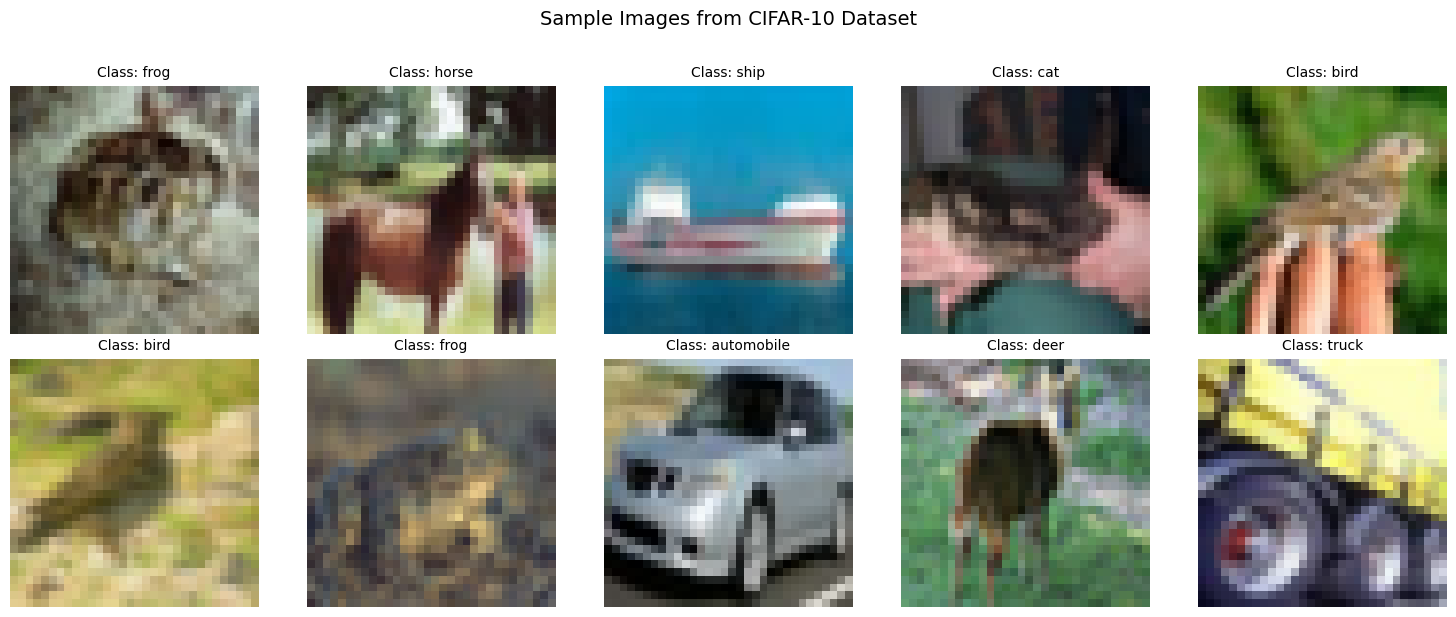

In [4]:
# Load CIFAR-10 dataset and normalize image data

# Automatically downloads the dataset from the official source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# The dataset is cached in ~/.keras/datasets/ (or C:\Users\<username>\.keras\datasets\ on Windows)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# CIFAR-10 class names - as defined in the official dataset.
# The labels 0-9 correspond to these classes in order
class_names = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

# Create proper train/validation split with stratification (20% validation)
# This ensures balanced class distribution in both train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train  # Ensures balanced class distribution
)

print(f"\nAfter split:")
print(f"Training:   {x_train.shape}, {y_train.shape} ({len(x_train)} samples)")
print(f"Validation: {x_val.shape}, {y_val.shape} ({len(x_val)} samples)")
print(f"Test:       {x_test.shape}, {y_test.shape} ({len(x_test)} samples)")

# Visualize 10 sample images from the dataset with their labels
print("\n10 sample images from the dataset")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    sample_img = x_train[i]
    label = y_train[i]
    
    axes[row, col].imshow(sample_img)
    axes[row, col].set_title(f"Class: {class_names[label]}", fontsize=10)
    axes[row, col].axis('off')
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 2. Data Augmentation & Efficient Data Pipelines
### Apply data augmentation (rotation, flipping, shifts) and measure improvement


In [ ]:
# Build efficient tf.data pipelines

# BATCH_SIZE: Number of samples processed together in one training step
#With 40,000 training images and batch size 128, you get ~313 batches per epoch (40,000 ÷ 128)
BATCH_SIZE = 128

# AUTOTUNE: TensorFlow's automatic optimization for data pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

# IMG_SIZE: Target image dimensions for MobileNetV2 input
# - CIFAR-10 images are 32x32, but MobileNetV2 expects larger images
# - 96x96 is a good size: larger than 32x32 but smaller than standard 224x224
IMG_SIZE = 96  # for MobileNetV2

# Data augmentation (Task 6: Apply rotation, flipping, and shifts)
# - Random rotation (up to 15 degrees ≈ 0.262 radians)
# - Random horizontal flipping /vertical shifts
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(15.0 / 180.0 * np.pi),  # 15 degrees in radians
    ],
    name="data_augmentation",
)

def preprocess_for_transfer(image, label, augment=False):
    # Original CIFAR is 32x32; resize for MobileNetV2
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # MobileNetV2 preprocessing
    if augment:
        image = data_augmentation(image)
    return image, label

def preprocess_for_custom_cnn(image, label, augment=False):
    if augment:
        # Task 6: Horizontal flipping and shifts
        image = tf.image.random_flip_left_right(image)
        # Random horizontal and vertical shifts (10% range = ~3 pixels for 32x32)
        # Use padding + random crop to simulate translation
        image = tf.image.resize_with_pad(image, 38, 38)  # Add 6 pixels padding (3 on each side)
        image = tf.image.random_crop(image, [32, 32, 3])  # Random crop back to 32x32
    return image, label

# Training dataset for transfer model
train_ds_transfer = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=True),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Test dataset for transfer model
test_ds_transfer = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess_for_transfer(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Training dataset for custom CNN
train_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(len(x_train))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=True),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Validation dataset for custom CNN (use proper validation set, NOT test set)
val_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Test dataset for custom CNN
test_ds_custom = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess_for_custom_cnn(x, y, augment=False),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


# Visualize augmented images (Task 6: Visualize augmented image examples)
print("\nVisualizing augmented images...")

# Create augmentation layers once for visualization
viz_flip_layer = layers.RandomFlip("horizontal", seed=42)
viz_rotation_layer = layers.RandomRotation(15.0 / 180.0 * np.pi, seed=42)

# Build layers with a dummy input to ensure proper initialization
dummy_input = tf.zeros((1, IMG_SIZE, IMG_SIZE, 3))
_ = viz_flip_layer(dummy_input, training=True)
_ = viz_rotation_layer(dummy_input, training=True)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original image
    sample_img = x_train[i]
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title(f"Original\nClass: {class_names[y_train[i]]}")
    axes[0, i].axis('off')
    
    # Augmented image - resize and apply augmentation for visualization
    # Ensure correct shape: (batch, height, width, channels)
    img_resized = tf.expand_dims(sample_img, 0)  # Add batch dimension: (1, 32, 32, 3)
    img_resized = tf.image.resize(img_resized, (IMG_SIZE, IMG_SIZE))  # (1, 96, 96, 3)
    # Apply augmentation layers
    aug_img = viz_flip_layer(img_resized, training=True)
    aug_img = viz_rotation_layer(aug_img, training=True)
    aug_img = aug_img.numpy()[0]  # Remove batch dimension: (96, 96, 3)
    # Clip to valid range for display
    aug_img = np.clip(aug_img, 0, 1)
    axes[1, i].imshow(aug_img)
    axes[1, i].set_title("Augmented\n(Rotated & Flipped)")
    axes[1, i].axis('off')
plt.tight_layout()
plt.suptitle("Data Augmentation Examples - Transfer Model (Task 6)", y=1.02, fontsize=14)
plt.show()

# Also visualize custom CNN augmentation
print("Visualizing custom CNN augmentation...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    sample_img = x_train[i]
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title(f"Original\nClass: {class_names[y_train[i]]}")
    axes[0, i].axis('off')
    
    # Apply custom CNN augmentation
    aug_img, _ = preprocess_for_custom_cnn(sample_img, y_train[i], augment=True)
    aug_img = aug_img.numpy() if hasattr(aug_img, 'numpy') else aug_img
    axes[1, i].imshow(aug_img)
    axes[1, i].set_title("Augmented\n(Flipped & Shifted)")
    axes[1, i].axis('off')
plt.tight_layout()
plt.suptitle("Data Augmentation Examples - Custom CNN (Task 6)", y=1.02, fontsize=14)
plt.show()
print("Augmentation visualization completed.")